In [1]:
import numpy as np
from PIL import Image
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.transforms import Compose, ToTensor, Normalize,ToPILImage, Resize
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR, CyclicLR, LambdaLR
from stepbystep.v0 import StepByStep

In [2]:
temp_transform = Compose([Resize(28), ToTensor(),])
temp_dataset = ImageFolder(root="data/rps", transform=temp_transform)

temp_dataset[0][0].shape, temp_dataset[0][1]

(torch.Size([3, 28, 28]), 0)

In [3]:
temp_loader = DataLoader(temp_dataset, batch_size=16)

In [4]:
first_images, first_labels = next(iter(temp_loader))
StepByStep.statistics_per_channel(first_images, first_labels)

tensor([[16.0000, 16.0000, 16.0000],
        [13.8748, 13.3048, 13.1962],
        [ 3.0507,  3.8268,  3.9754]])

In [5]:
results = StepByStep.loader_apply(temp_loader, StepByStep.statistics_per_channel)
results

tensor([[2520.0000, 2520.0000, 2520.0000],
        [2142.5356, 2070.0806, 2045.1444],
        [ 526.3025,  633.0677,  669.9556]])

In [6]:
normalizer = StepByStep.make_normalizer(temp_loader)
normalizer

Normalize(mean=tensor([0.8502, 0.8215, 0.8116]), std=tensor([0.2089, 0.2512, 0.2659]))

In [7]:
composer = Compose([Resize(28), ToTensor(), normalizer])

train_data = ImageFolder(root="data/rps", transform=composer)
val_data = ImageFolder(root='data/rps-test-set', transform=composer)

train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16)

In [8]:
class CNN2(nn.Module):
    def __init__(self, n_features, p=0.0):
        super().__init__()
        self.n_features = n_features
        self.p = p
        # 创建卷积层
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=n_features,
                               kernel_size=3)

        self.conv2 = nn.Conv2d(in_channels=n_features,
                               out_channels=n_features,
                               kernel_size=3)
        # 创建线性层
        self.fc1 = nn.Linear(n_features * 5 * 5, 50)
        self.fc2 = nn.Linear(50, 3)
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        # 特征化器
        # 第一个卷积模块
        # 3@28x28 -> n_features@26x26 -> n_features@13x13
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # 第二个卷积模块
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # 输入维度(n_features@5x5)
        # 输出维度(n_features * 5 * 5)
        x = nn.Flatten()(x)
        return x

    def classifier(self, x):
        # 分类器
        # 隐藏层
        # 输入维度(n_features * 5 * 5)
        # 输出维度(50)
        if self.p > 0.0:
            x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)

        # 输出层
        # 输入维度（50）
        # 输出维度（3）
        if self.p > 0.0:
            x = self.drop(x)
        x = self.fc2(x)
        return x
    
    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

In [9]:
dropping_model = nn.Sequential(nn.Dropout(p = 0.5))
spaced_points = torch.linspace(.1, 1.1, 11)
spaced_points

tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000,
        1.0000, 1.1000])

In [10]:
torch.manual_seed(44)

dropping_model.train()
output_train = dropping_model(spaced_points)
output_train

tensor([0.0000, 0.0000, 0.6000, 0.8000, 0.0000, 0.0000, 1.4000, 0.0000, 1.8000,
        2.0000, 2.2000])

In [11]:
torch.manual_seed(13)
model_cnn2 = CNN2(n_features=5, p=0.3)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn2 = optim.Adam(model_cnn2.parameters(), lr=3e-4)

In [12]:
sbs_cnn2 = StepByStep(model_cnn2, multi_loss_fn, optimizer_cnn2)
sbs_cnn2.set_loaders(train_loader, val_loader)
sbs_cnn2.train(10)

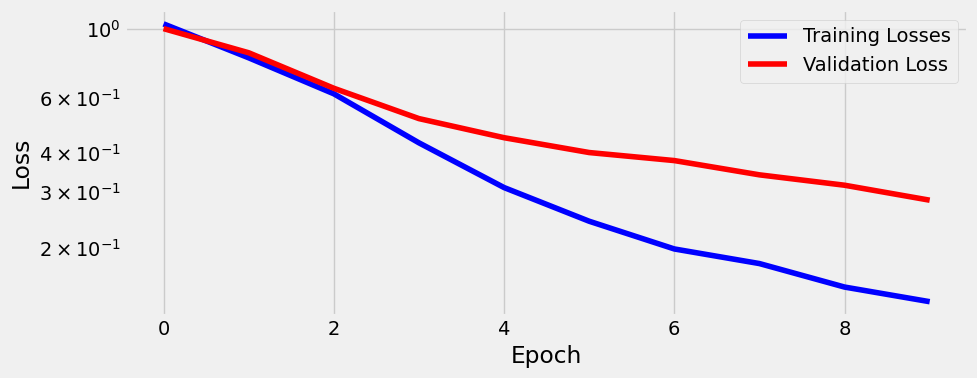

In [13]:
fig = sbs_cnn2.plot_losses()

In [14]:
StepByStep.loader_apply(val_loader, sbs_cnn2.correct)

tensor([[ 87, 124],
        [118, 124],
        [111, 124]])

In [15]:
torch.manual_seed(13)
# 配置模型
model_cnn2_nodrop = CNN2(n_features=5, p=0.0)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimzer_cnn2_nodrop = optim.Adam(model_cnn2_nodrop.parameters(), lr=3e-4)

sbs_cnn2_nodrop = StepByStep(model_cnn2_nodrop, multi_loss_fn, optimzer_cnn2_nodrop)
sbs_cnn2_nodrop.set_loaders(train_loader, val_loader)
sbs_cnn2_nodrop.train(10)

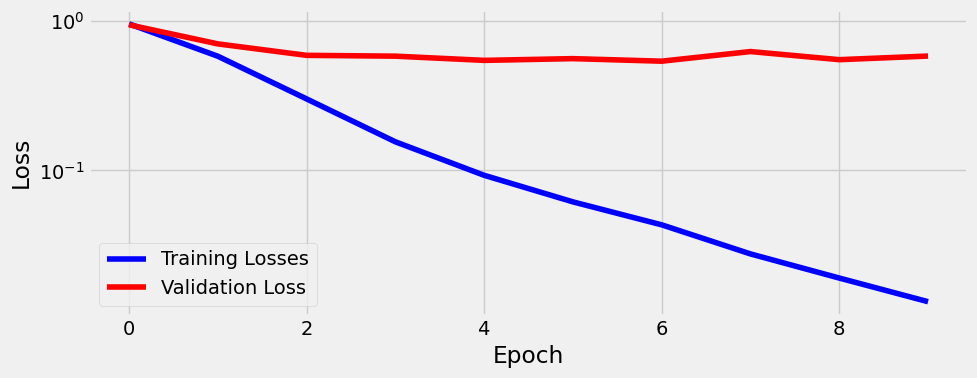

In [16]:
fig = sbs_cnn2_nodrop.plot_losses()

In [17]:
print(StepByStep.loader_apply(train_loader, sbs_cnn2_nodrop.correct).sum(axis=0),
      StepByStep.loader_apply(val_loader, sbs_cnn2_nodrop.correct).sum(axis=0))

tensor([2520, 2520]) tensor([294, 372])


In [18]:
print(StepByStep.loader_apply(train_loader, sbs_cnn2.correct).sum(axis=0),
      StepByStep.loader_apply(val_loader, sbs_cnn2.correct).sum(axis=0))

tensor([2498, 2520]) tensor([316, 372])


In [19]:
model_cnn2.conv1.weight.shape

torch.Size([5, 3, 3, 3])

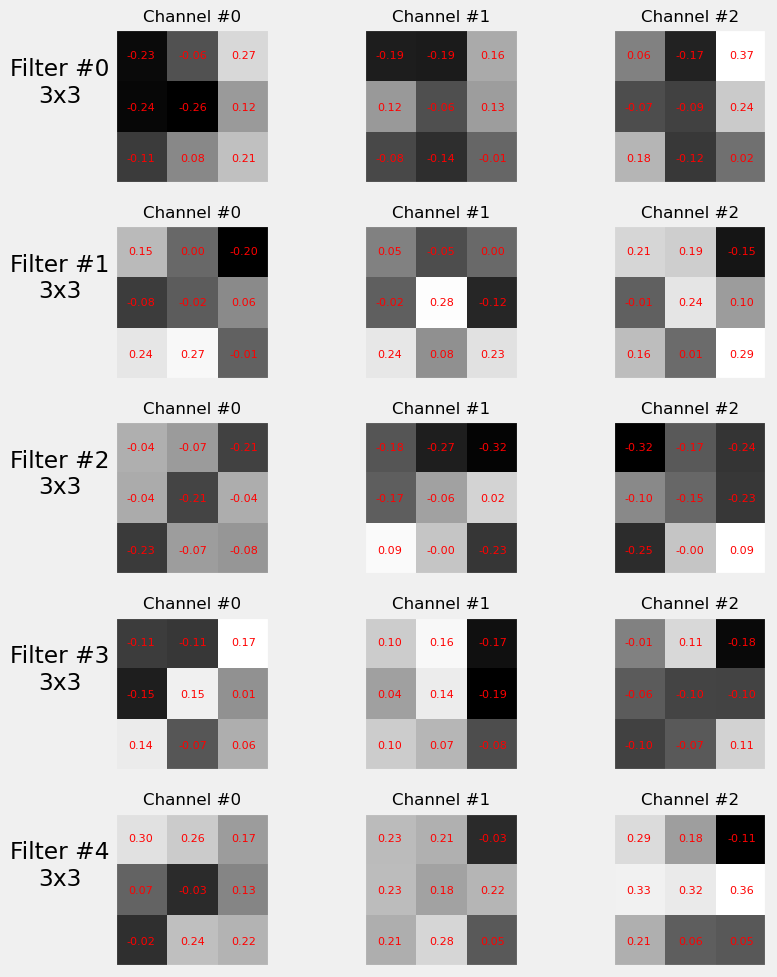

In [20]:
fig = sbs_cnn2.visualize_filter('conv1')

In [21]:
model_cnn2.conv2.weight.shape

torch.Size([5, 5, 3, 3])

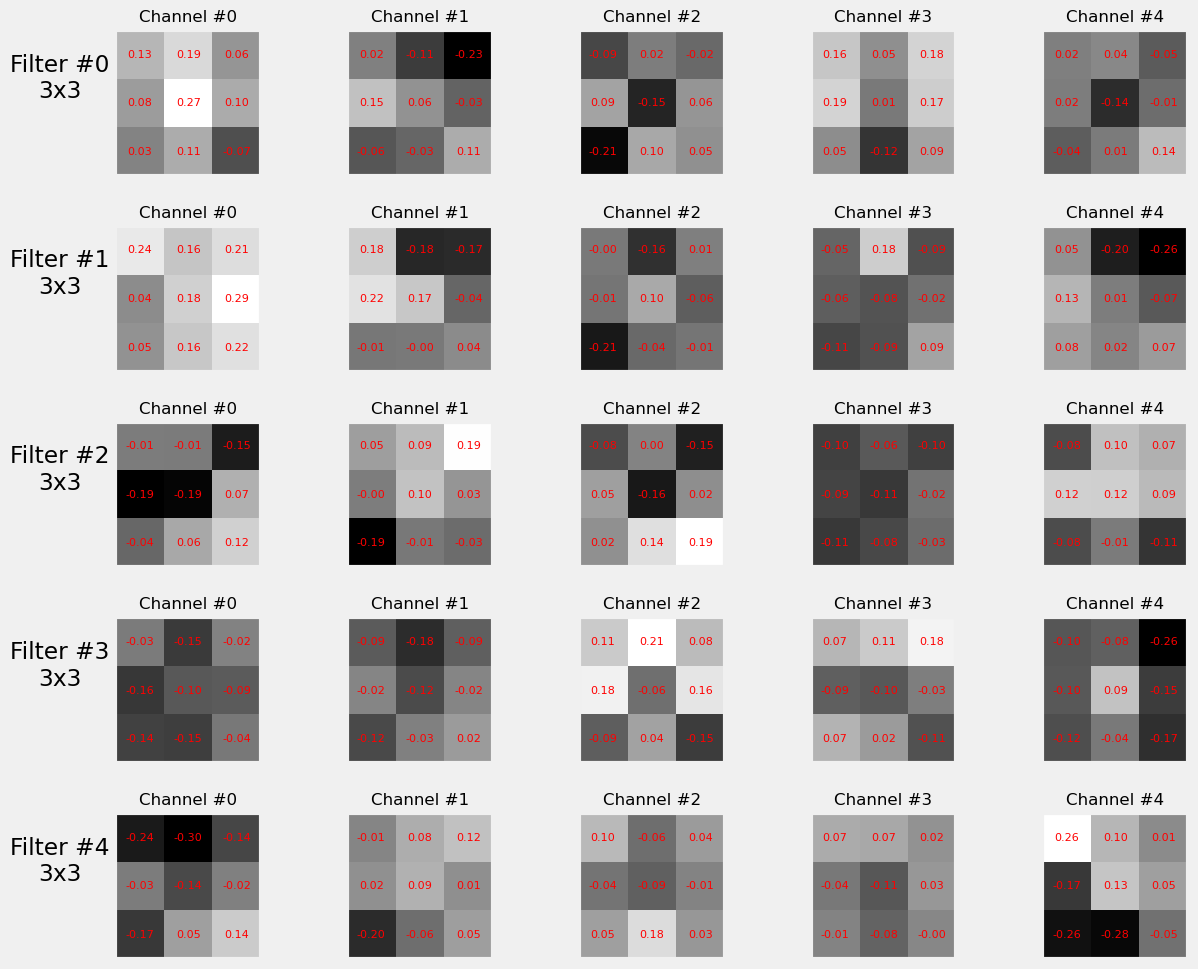

In [22]:
fig = sbs_cnn2.visualize_filter('conv2')

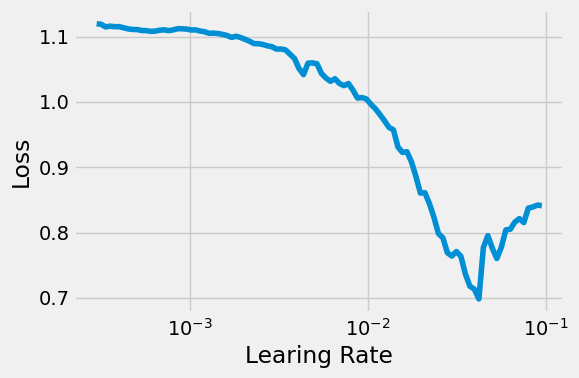

In [23]:
torch.manual_seed(13)

new_model = CNN2(n_features=5, p=0.3)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
new_optimizer = optim.Adam(new_model.parameters(), lr=3e-4)

sbs_new = StepByStep(new_model, multi_loss_fn, new_optimizer)
tracking, fig = sbs_new.lr_range_test(train_loader, end_lr=1e-1, num_iter=100)

In [28]:
new_optimizer = optim.Adam(new_model.parameters(), lr=5e-3)
sbs_new.set_optimizer(new_optimizer)
sbs_new.set_loaders(train_loader, val_loader)
sbs_new.train(10)

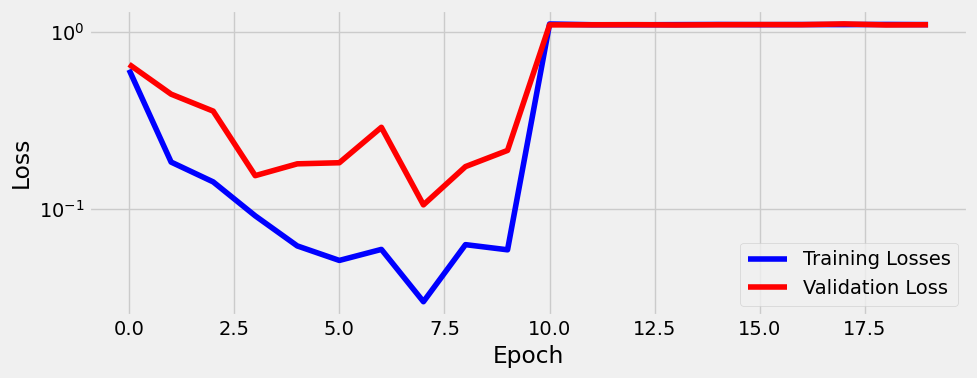

In [29]:
fig = sbs_new.plot_losses()